In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [0]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

使用paddle实现房价预测

In [31]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
from sklearn.metrics import r2_score

def load_data():
    # 从文件导入数据
    datafile = 'data/data49224/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


class Regressor(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是13，输出维度是1
        self.fc1 = Linear(in_features=13, out_features=100)
        self.fc2 = Linear(in_features=100, out_features=1)

    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x


# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())


EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        if iter_id%50==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

epoch: 0, iter: 0, loss is: [0.07831255]
epoch: 1, iter: 0, loss is: [0.01426903]
epoch: 2, iter: 0, loss is: [0.00989218]
epoch: 3, iter: 0, loss is: [0.03912247]
epoch: 4, iter: 0, loss is: [0.03260785]
epoch: 5, iter: 0, loss is: [0.05925754]
epoch: 6, iter: 0, loss is: [0.01505163]
epoch: 7, iter: 0, loss is: [0.01314226]
epoch: 8, iter: 0, loss is: [0.01887406]
epoch: 9, iter: 0, loss is: [0.00588439]


进行测试

In [33]:
xx = test_data[:, 0:13]
yy = test_data[:, [13]]

house_features = paddle.to_tensor(xx)
prices = paddle.to_tensor(yy)

yy_pred = model(house_features)

a_loss = np.sqrt(((yy_pred.numpy() - yy) ** 2).mean())
print(a_loss)
r2=r2_score(yy, yy_pred, multioutput='variance_weighted')
print(r2)

0.1299184
-0.2711648291194919


使用python与numpy实现房价预测

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import math
#导入numpy，pandas

def load_data():
    # 从文件导入数据
    datafile = 'data/data49224/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

hidden_dim = 100

w1 = np.random.randn(x.shape[1],hidden_dim)
w2 = np.random.randn(hidden_dim,y.shape[1])

lr = 1e-06

losses = []
for i in range(100):
    #迭代500次
    #前向传播
    h = x.dot(w1) #隐藏层
    h_relu = np.maximum(h,0) #relu激活函数
    y_hat = h_relu.dot(w2)
    
    #计算损失
    loss = np.square(y_hat - y).sum()/len(y_hat)
    losses.append(loss)
    
    #计算梯度
    y_hat_grad = 2.0*(y_hat-y)
    w2_grad = h_relu.T.dot(y_hat_grad)
    h_relu_grad = y_hat_grad.dot(w2.T)
    h_grad = h_relu_grad.copy()
    h_grad[h < 0] = 0
    w1_grad = x.T.dot(h_grad)
    
    #更新参数
    w1 = w1 - lr*w1_grad
    w2 = w2 - lr*w2_grad
    
    if i%10 == 0:
        print("epoch "+str(i)+" loss:",loss)

epoch 0 loss: 13.41863193557366
epoch 10 loss: 12.624472337774511
epoch 20 loss: 11.92628098937508
epoch 30 loss: 11.306850711064122
epoch 40 loss: 10.752403551407639
epoch 50 loss: 10.251627061951122
epoch 60 loss: 9.797434808853678
epoch 70 loss: 9.382661674785723
epoch 80 loss: 9.003071057436543
epoch 90 loss: 8.654534675280427
epoch 100 loss: 8.333669645535478
epoch 110 loss: 8.037455735074571
epoch 120 loss: 7.763082172783301
epoch 130 loss: 7.50812632305749
epoch 140 loss: 7.270446094345604
epoch 150 loss: 7.048713071484074
epoch 160 loss: 6.841312342792019
epoch 170 loss: 6.6471111468690225
epoch 180 loss: 6.464974672812303
epoch 190 loss: 6.293824275287203


进行测试

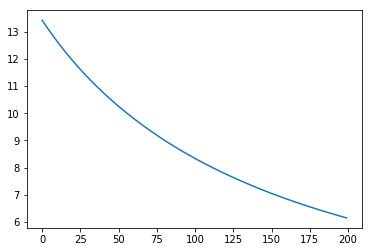

3.7406329550353123
-1052.7818992702794


In [36]:
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

#测试集进行验证
test = test_data[:, 0:13]
test_label = test_data[:, [13]]

h = test.dot(w1) #隐藏层
h_relu = np.maximum(h,0) #relu激活函数
test_label_pred = h_relu.dot(w2)

a_loss = np.sqrt(((test_label_pred - test_label) ** 2).mean())
print(a_loss)
r2=r2_score(test_label, test_label_pred, multioutput='variance_weighted')
print(r2)

深度学习的发展历史 
作为机器学习最重要的一个分支，深度学习近年来发展迅猛，在国内外都引起了广泛的关注。然而深度学习的火热也不是一时兴起的，而是经历了一段漫长的发展史。接下来我们了解一下深度学习的发展历程。 1.深度学习的起源阶段 1943年，心里学家麦卡洛克和数学逻辑学家皮兹发表论文《神经活动中内在思想的逻辑演算》，提出了MP模型。MP模型是模仿神经元的结构和工作原理，构成出的一个基于神经网络的数学模型，本质上是一种“模拟人类大脑”的神经元模型。MP模型作为人工神经网络的起源，开创了人工神经网络的新时代，也奠定了神经网络模型的基础。 1949年，加拿大著名心理学家唐纳德·赫布在《行为的组织》中提出了一种基于无监督学习的规则——海布学习规则(Hebb Rule)。海布规则模仿人类认知世界的过程建立一种“网络模型”，该网络模型针对训练集进行大量的训练并提取训练集的统计特征，然后按照样本的相似程度进行分类，把相互之间联系密切的样本分为一类，这样就把样本分成了若干类。海布学习规则与“条件反射”机理一致，为以后的神经网络学习算法奠定了基础，具有重大的历史意义。 20世纪50年代末，在MP模型和海布学习规则的研究基础上，美国科学家罗森布拉特发现了一种类似于人类学习过程的学习算法——感知机学习。并于1958年，正式提出了由两层神经元组成的神经网络，称之为“感知器”。感知器本质上是一种线性模型，可以对输入的训练集数据进行二分类，且能够在训练集中自动更新权值。感知器的提出吸引了大量科学家对人工神经网络研究的兴趣，对神经网络的发展具有里程碑式的意义。 但随着研究的深入，在1969年，“AI之父”马文·明斯基和LOGO语言的创始人西蒙·派珀特共同编写了一本书籍《感知器》，在书中他们证明了单层感知器无法解决线性不可分问题（例如：异或问题）。由于这个致命的缺陷以及没有及时推广感知器到多层神经网络中，在20世纪70年代，人工神经网络进入了第一个寒冬期，人们对神经网络的研究也停滞了将近20年。 2.深度学习的发展阶段 1982年，著名物理学家约翰·霍普菲尔德发明了Hopfield神经网络。Hopfield神经网络是一种结合存储系统和二元系统的循环神经网络。Hopfield网络也可以模拟人类的记忆，根据激活函数的选取不同，有连续型和离散型两种类型，分别用于优化计算和联想记忆。但由于容易陷入局部最小值的缺陷，该算法并未在当时引起很大的轰动。 直到1986年，深度学习之父杰弗里·辛顿提出了一种适用于多层感知器的反向传播算法——BP算法。BP算法在传统神经网络正向传播的基础上，增加了误差的反向传播过程。反向传播过程不断地调整神经元之间的权值和阈值，直到输出的误差达到减小到允许的范围之内，或达到预先设定的训练次数为止。BP算法完美的解决了非线性分类问题，让人工神经网络再次的引起了人们广泛的关注。
图2 深度学习之父杰弗里·辛顿 但是由于八十年代计算机的硬件水平有限，如：运算能力跟不上，这就导致当神经网络的规模增大时，再使用BP算法会出现“梯度消失”的问题。这使得BP算法的发展受到了很大的限制。再加上90年代中期，以SVM为代表的其它浅层机器学习算法被提出，并在分类、回归问题上均取得了很好的效果，其原理又明显不同于神经网络模型，所以人工神经网络的发展再次进入了瓶颈期。 3.深度学习的爆发阶段 2006年，杰弗里·辛顿以及他的学生鲁斯兰·萨拉赫丁诺夫正式提出了深度学习的概念。他们在世界顶级学术期刊《科学》发表的一篇文章中详细的给出了“梯度消失”问题的解决方案——通过无监督的学习方法逐层训练算法，再使用有监督的反向传播算法进行调优。该深度学习方法的提出，立即在学术圈引起了巨大的反响，以斯坦福大学、多伦多大学为代表的众多世界知名高校纷纷投入巨大的人力、财力进行深度学习领域的相关研究。而后又在迅速蔓延到工业界中。 2012年，在著名的ImageNet图像识别大赛中，杰弗里·辛顿领导的小组采用深度学习模型AlexNet一举夺冠。AlexNet采用ReLU激活函数，从根本上解决了梯度消失问题，并采用GPU极大的提高了模型的运算速度。同年，由斯坦福大学著名的吴恩达教授和世界顶尖计算机专家Jeff Dean共同主导的深度神经网络——DNN技术在图像识别领域取得了惊人的成绩，在ImageNet评测中成功的把错误率从26％降低到了15％。深度学习算法在世界大赛的脱颖而出，也再一次吸引了学术界和工业界对于深度学习领域的关注。 随着深度学习技术的不断进步以及数据处理能力的不断提升，2014年，Facebook基于深度学习技术的DeepFace项目，在人脸识别方面的准确率已经能达到97%以上，跟人类识别的准确率几乎没有差别。这样的结果也再一次证明了深度学习算法在图像识别方面的一骑绝尘。 2016年，随着谷歌公司基于深度学习开发的AlphaGo以4:1的比分战胜了国际顶尖围棋高手李世石，深度学习的热度一时无两。后来，AlphaGo又接连和众多世界级围棋高手过招，均取得了完胜。这也证明了在围棋界，基于深度学习技术的机器人已经超越了人类。 2017年，基于强化学习算法的AlphaGo升级版AlphaGo Zero横空出世。其采用“从零开始”、“无师自通”的学习模式，以100:0的比分轻而易举打败了之前的AlphaGo。除了围棋，它还精通国际象棋等其它棋类游戏，可以说是真正的棋类“天才”。此外在这一年，深度学习的相关算法在医疗、金融、艺术、无人驾驶等多个领域均取得了显著的成果。所以，也有专家把2017年看作是深度学习甚至是人工智能发展最为突飞猛进的一年。

人工智能、机器学习与深度学习之间的关系与区别 
人工智能：从概念提出到走向繁荣 1956年，几个计算机科学家相聚在达特茅斯会议，提出了“人工智能”的概念，梦想着用当时刚刚出现的计算机来构造复杂的、拥有与人类智慧同样本质特性的机器。其后，人工智能就一直萦绕于人们的脑海之中，并在科研实验室中慢慢孵化。之后的几十年，人工智能一直在两极反转，或被称作人类文明耀眼未来的预言，或被当成技术疯子的狂想扔到垃圾堆里。直到2012年之前，这两种声音还在同时存在。 2012年以后，得益于数据量的上涨、运算力的提升和机器学习新算法（深度学习）的出现，人工智能开始大爆发。据领英近日发布的《全球AI领域人才报告》显示，截至2017年一季度，基于领英平台的全球AI（人工智能）领域技术人才数量超过190万，仅国内人工智能人才缺口达到500多万。 人工智能的研究领域也在不断扩大，图二展示了人工智能研究的各个分支，包括专家系统、机器学习、进化计算、模糊逻辑、计算机视觉、自然语言处理、推荐系统等。
图二 人工智能研究分支 但目前的科研工作都集中在弱人工智能这部分，并很有希望在近期取得重大突破，电影里的人工智能多半都是在描绘强人工智能，而这部分在目前的现实世界里难以真正实现（通常将人工智能分为弱人工智能和强人工智能，前者让机器具备观察和感知的能力，可以做到一定程度的理解和推理，而强人工智能让机器获得自适应能力，解决一些之前没有遇到过的问题）。 弱人工智能有希望取得突破，是如何实现的，“智能”又从何而来呢？这主要归功于一种实现人工智能的方法——机器学习。 
机器学习：一种实现人工智能的方法 机器学习最基本的做法，是使用算法来解析数据、从中学习，然后对真实世界中的事件做出决策和预测。与传统的为解决特定任务、硬编码的软件程序不同，机器学习是用大量的数据来“训练”，通过各种算法从数据中学习如何完成任务。 举个简单的例子，当我们浏览网上商城时，经常会出现商品推荐的信息。这是商城根据你往期的购物记录和冗长的收藏清单，识别出这其中哪些是你真正感兴趣，并且愿意购买的产品。这样的决策模型，可以帮助商城为客户提供建议并鼓励产品消费。 机器学习直接来源于早期的人工智能领域，传统的算法包括决策树、聚类、贝叶斯分类、支持向量机、EM、Adaboost等等。从学习方法上来分，机器学习算法可以分为监督学习（如分类问题）、无监督学习（如聚类问题）、半监督学习、集成学习、深度学习和强化学习。 传统的机器学习算法在指纹识别、基于Haar的人脸检测、基于HoG特征的物体检测等领域的应用基本达到了商业化的要求或者特定场景的商业化水平，但每前进一步都异常艰难，直到深度学习算法的出现。 
深度学习：一种实现机器学习的技术 深度学习本来并不是一种独立的学习方法，其本身也会用到有监督和无监督的学习方法来训练深度神经网络。但由于近几年该领域发展迅猛，一些特有的学习手段相继被提出（如残差网络），因此越来越多的人将其单独看作一种学习的方法。 最初的深度学习是利用深度神经网络来解决特征表达的一种学习过程。深度神经网络本身并不是一个全新的概念，可大致理解为包含多个隐含层的神经网络结构。为了提高深层神经网络的训练效果，人们对神经元的连接方法和激活函数等方面做出相应的调整。其实有不少想法早年间也曾有过，但由于当时训练数据量不足、计算能力落后，因此最终的效果不尽如人意。 深度学习摧枯拉朽般地实现了各种任务，使得似乎所有的机器辅助功能都变为可能。无人驾驶汽车，预防性医疗保健，甚至是更好的电影推荐，都近在眼前，或者即将实现。 三者的区别和联系 机器学习是一种实现人工智能的方法，深度学习是一种实现机器学习的技术。我们就用最简单的方法——同心圆，可视化地展现出它们三者的关系。 图三 三者关系示意图 目前，业界有一种错误的较为普遍的意识，即“深度学习最终可能会淘汰掉其他所有机器学习算法”。这种意识的产生主要是因为，当下深度学习在计算机视觉、自然语言处理领域的应用远超过传统的机器学习方法，并且媒体对深度学习进行了大肆夸大的报道。 深度学习，作为目前最热的机器学习方法，但并不意味着是机器学习的终点。起码目前存在以下问题：
深度学习模型需要大量的训练数据，才能展现出神奇的效果，但现实生活中往往会遇到小样本问题，此时深度学习方法无法入手，传统的机器学习方法就可以处理；
有些领域，采用传统的简单的机器学习方法，可以很好地解决了，没必要非得用复杂的深度学习方法；
深度学习的思想，来源于人脑的启发，但绝不是人脑的模拟，举个例子，给一个三四岁的小孩看一辆自行车之后，再见到哪怕外观完全不同的自行车，小孩也十有八九能做出那是一辆自行车的判断，也就是说，人类的学习过程往往不需要大规模的训练数据，而现在的深度学习方法显然不是对人脑的模拟。

神经元、单层感知机与多层感知机 
神经元 　　
对于神经元的研究由来已久，1904年生物学家就已经知晓了神经元的组成结构。 　　
一个神经元通常具有多个树突，主要用来接受传入信息；而轴突只有一条，轴突尾端有许多轴突末梢可以给其他多个神经元传递信息。轴突末梢跟其他神经元的树突产生连接，从而传递信号。这个连接的位置在生物学上叫做“突触”。 　　
人脑中的神经元形状可以用下图做简单的说明：
1943年，心理学家McCulloch和数学家Pitts参考了生物神经元的结构，发表了抽象的神经元模型MP。在下文中，我们会具体介绍神经元模型。
神经元模型是一个包含输入，输出与计算功能的模型。输入可以类比为神经元的树突，而输出可以类比为神经元的轴突，计算则可以类比为细胞核。 　　
连接是神经元中最重要的东西。每一个连接上都有一个权重。 　　
一个神经网络的训练算法就是让权重的值调整到最佳，以使得整个网络的预测效果最好。
我们使用a来表示输入，用w来表示权值。一个表示连接的有向箭头可以这样理解：在初端，传递的信号大小仍然是a，端中间有加权参数w，经过这个加权后的信号会变成aw，因此在连接的末端，信号的大小就变成了aw。 　　在其他绘图模型里，有向箭头可能表示的是值的不变传递。而在神经元模型里，每个有向箭头表示的是值的加权传递。
可见z是在输入和权值的线性加权和叠加了一个函数g的值。在MP模型里，函数g是sgn函数，也就是取符号函数。这个函数当输入大于0时，输出1，否则输出0。
下面对神经元模型的图进行一些扩展。首先将sum函数与sgn函数合并到一个圆圈里，代表神经元的内部计算。其次，把输入a与输出z写到连接线的左上方，便于后面画复杂的网络。最后说明，一个神经元可以引出多个代表输出的有向箭头，但值都是一样的。 
神经元可以看作一个计算与存储单元。计算是神经元对其的输入进行计算功能。存储是神经元会暂存计算结果，并传递到下一层。
当我们用“神经元”组成网络以后，描述网络中的某个“神经元”时，我们更多地会用“单元”（unit）来指代。同时由于神经网络的表现形式是一个有向图，有时也会用“节点”（node）来表达同样的意思。 单层感知机 1958年，计算科学家Rosenblatt提出了由两层神经元组成的神经网络。他给它起了一个名字--“感知器”（Perceptron）（有的文献翻译成“感知机”，下文统一用“感知器”来指代）。 
感知器是当时首个可以学习的人工神经网络。Rosenblatt现场演示了其学习识别简单图像的过程，在当时的社会引起了轰动。 　
人们认为已经发现了智能的奥秘，许多学者和科研机构纷纷投入到神经网络的研究中。美国军方大力资助了神经网络的研究，并认为神经网络比“原子弹工程”更重要。这段时间直到1969年才结束，这个时期可以看作神经网络的第一次高潮。
下面来说明感知器模型。 　　
在原来MP模型的“输入”位置添加神经元节点，标志其为“输入单元”。其余不变，于是我们就有了下图：从本图开始，我们将权值w1, w2, w3写到“连接线”的中间。
在“感知器”中，有两个层次。分别是输入层和输出层。输入层里的“输入单元”只负责传输数据，不做计算。输出层里的“输出单元”则需要对前面一层的输入进行计算。 　
我们把需要计算的层次称之为“计算层”，并把拥有一个计算层的网络称之为“单层神经网络”。有一些文献会按照网络拥有的层数来命名，例如把“感知器”称为两层神经网络。但在本文里，我们根据计算层的数量来命名。 　
假如我们要预测的目标不再是一个值，而是一个向量，例如[2,3]。那么可以在输出层再增加一个“输出单元”。
可以看到，z2的计算中除了三个新的权值：w4，w5，w6以外，其他与z1是一样的。
目前的表达公式有一点不让人满意的就是：w4，w5，w6是后来加的，很难表现出跟原先的w1，w2，w3的关系。 
因此我们改用二维的下标，用wx,y来表达一个权值。下标中的x代表后一层神经元的序号，而y代表前一层神经元的序号（序号的顺序从上到下）。 　
例如，w1,2代表后一层的第1个神经元与前一层的第2个神经元的连接的权值（这种标记方式参照了Andrew Ng的课件）。
如果我们仔细看输出的计算公式，会发现这两个公式就是线性代数方程组。因此可以用矩阵乘法来表达这两个公式。 
例如，输入的变量是[a1，a2，a3]T（代表由a1，a2，a3组成的列向量），用向量a来表示。方程的左边是[z1，z2]T，用向量z来表示。 
系数则是矩阵W（2行3列的矩阵，排列形式与公式中的一样）。
于是，输出公式可以改写成： g(W * a) = z 　
这个公式就是神经网络中从前一层计算后一层的矩阵运算。 　
与神经元模型不同，感知器中的权值是通过训练得到的。因此，根据以前的知识我们知道，感知器类似一个逻辑回归模型，可以做线性分类任务。
我们可以用决策分界来形象的表达分类的效果。决策分界就是在二维的数据平面中划出一条直线，当数据的维度是3维的时候，就是划出一个平面，当数据的维度是n维时，就是划出一个n-1维的超平面。 　
感知器只能做简单的线性分类任务。 多层感知机 两层神经网络是本文的重点，因为正是在这时候，神经网络开始了大范围的推广与使用。
Minsky说过单层神经网络无法解决异或问题。但是当增加一个计算层以后，两层神经网络不仅可以解决异或问题，而且具有非常好的非线性分类效果。不过两层神经网络的计算是一个问题，没有一个较好的解法。 
1986年，Rumelhar和Hinton等人提出了反向传播（Backpropagation，BP）算法，解决了两层神经网络所需要的复杂计算量问题，从而带动了业界使用两层神经网络研究的热潮。目前，大量的教授神经网络的教材，都是重点介绍两层（带一个隐藏层）神经网络的内容。 　
这时候的Hinton还很年轻，30年以后，正是他重新定义了神经网络，带来了神经网络复苏的又一春。
两层神经网络除了包含一个输入层，一个输出层以外，还增加了一个中间层。此时，中间层和输出层都是计算层。我们扩展上节的单层神经网络，在右边新加一个层次（只含有一个节点）。 　　现在，我们的权值矩阵增加到了两个，我们用上标来区分不同层次之间的变量。 
例如ax(y)代表第y层的第x个节点。z1，z2变成了a1(2)，a2(2)。
计算最终输出z的方式是利用了中间层的a1(2)，a2(2)和第二个权值矩阵计算得到的.
假设我们的预测目标是一个向量，那么与前面类似，只需要在“输出层”再增加节点即可。
我们使用向量和矩阵来表示层次中的变量。a(1)，a(2)，z是网络中传输的向量数据。W(1)和W(2)是网络的矩阵参数。
使用矩阵运算来表达整个计算公式的话如下： g(W(1) * a(1)) = a(2); g(W(2) * a(2)) = z;
由此可见，使用矩阵运算来表达是很简洁的，而且也不会受到节点数增多的影响（无论有多少节点参与运算，乘法两端都只有一个变量）。因此神经网络的教程中大量使用矩阵运算来描述。 　　需要说明的是，至今为止，我们对神经网络的结构图的讨论中都没有提到偏置节点（bias unit）。事实上，这些节点是默认存在的。它本质上是一个只含有存储功能，且存储值永远为1的单元。在神经网络的每个层次中，除了输出层以外，都会含有这样一个偏置单元。正如线性回归模型与逻辑回归模型中的一样。 　
偏置单元与后一层的所有节点都有连接，我们设这些参数值为向量b，称之为偏置。
可以看出，偏置节点很好认，因为其没有输入（前一层中没有箭头指向它）。有些神经网络的结构图中会把偏置节点明显画出来，有些不会。一般情况下，我们都不会明确画出偏置节点。 　　在考虑了偏置以后的一个神经网络的矩阵运算如下： g(W(1) * a(1) + b(1)) = a(2); g(W(2) * a(2) + b(2)) = z;
需要说明的是，在两层神经网络中，我们不再使用sgn函数作为函数g，而是使用平滑函数sigmoid作为函数g。我们把函数g也称作激活函数（active function）。 　
事实上，神经网络的本质就是通过参数与激活函数来拟合特征与目标之间的真实函数关系。初学者可能认为画神经网络的结构图是为了在程序中实现这些圆圈与线，但在一个神经网络的程序中，既没有“线”这个对象，也没有“单元”这个对象。实现一个神经网络最需要的是线性代数库。

前向传播

如图所示，这里讲得已经很清楚了，前向传播的思想比较简单。 举个例子，假设上一层结点i,j,k,…等一些结点与本层的结点w有连接，那么结点w的值怎么算呢？就是通过上一层的i,j,k等结点以及对应的连接权值进行加权和运算，最终结果再加上一个偏置项（图中为了简单省略了），最后在通过一个非线性函数（即激活函数），如ReLu，sigmoid等函数，最后得到的结果就是本层结点w的输出。 最终不断的通过这种方法一层层的运算，得到输出层结果。 对于前向传播来说，不管维度多高，其过程都可以用如下公式表示： a 2 = σ( z 2 ) = σ ( a 1 ∗ W 2 + b 2 ) a^2 = \sigma(z^2) = \sigma(a^1 * W^2 + b^2)a2=σ(z2)=σ(a1∗W2+b2) 其中，上标代表层数，星号表示卷积，b表示偏置项bias，σ \sigmaσ表示激活函数。

反向传播
BackPropagation算法是多层神经网络的训练中举足轻重的算法。反向传播算法，简称BP算法，适合于多层神经元网络的一种学习算法，它建立在梯度下降法的基础上。BP网络的输入输出关系实质上是一种映射关系：一个n输入m输出的BP神经网络所完成的功能是从n维欧氏空间向m维欧氏空间中一有限域的连续映射，这一映射具有高度非线性。它的信息处理能力来源于简单非线性函数的多次复合，因此具有很强的函数复现能力。这是BP算法得以应用的基础。简单的理解，它的确就是复合函数的链式法则，但其在实际运算中的意义比链式法则要大的多。